<a href="https://colab.research.google.com/github/Akkki28/DeepLinUCB-recommender-system/blob/main/recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

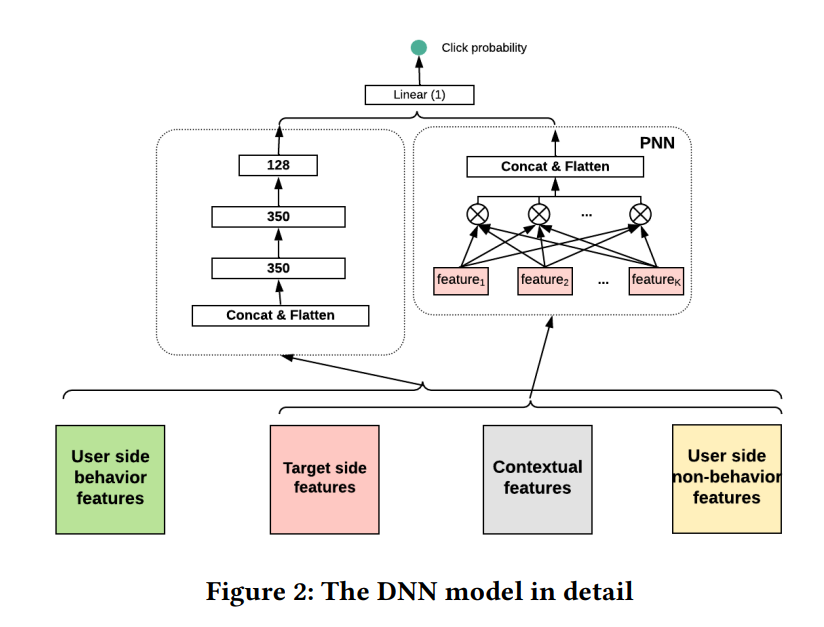

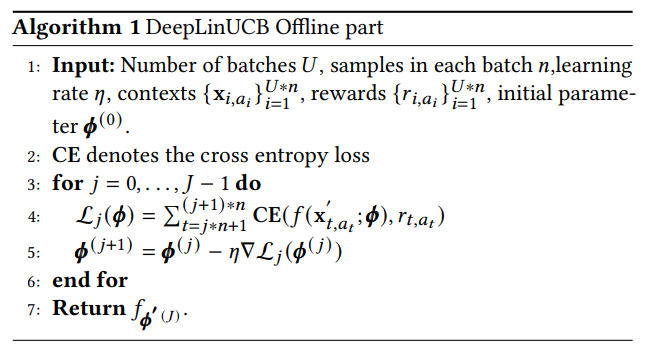

# Build the Model

In [2]:
#DNN model as given in the figure above
class DNN(nn.Module):
    def __init__(self, input_dim):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 350)
        self.fc2 = nn.Linear(350, 350)
        self.fc3 = nn.Linear(350, 128)
        self.fc4 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def context(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return x


# Train on Dataset

In [3]:
#Sample user dataset for training
data = {
    'age': [25, 30, 22, 35, 40, 29, 31, 21, 36, 28],
    'gender': [1, 0, 1, 1, 0, 1, 0, 1, 0, 0],  # 1-> male, 0-> female
    'device_type': [1, 0, 0, 1, 1, 1, 0, 1, 1, 0],  # 1-> TV, 0-> mobile
    'hour_of_day': [20, 18, 14, 22, 15, 19, 17, 23, 21, 16],
    'comedy': [1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
    'romance': [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
    'horror': [0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
    'action': [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],#one hot encoded version of genres
    'popularity': [0.7, 0.5, 0.9, 0.3, 0.8, 0.6, 0.4, 0.75, 0.85, 0.6],
    'watched': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0],  # Label
}

df = pd.DataFrame(data)
df.head()

,age,gender,device_type,hour_of_day,comedy,romance,horror,action,popularity,watched
0,25,1,1,20,1,0,0,0,0.7,1
1,30,0,0,18,0,1,0,0,0.5,0
2,22,1,0,14,1,0,0,0,0.9,1
3,35,1,1,22,0,0,1,0,0.3,0
4,40,0,1,15,1,0,0,1,0.8,1


In [4]:
X = df.drop(columns='watched').values
y = df['watched'].values

X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y).view(-1, 1)

input_dim = X.shape[1]
X.shape[1]

9

In [5]:
model = DNN(input_dim)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
def train_model(model, X_tensor, y_tensor, epochs=10, batch_size=2):
    model.train()
    for epoch in range(epochs):
        permutation = torch.randperm(X_tensor.size()[0])
        epoch_loss = 0
        for i in range(0, X_tensor.size()[0], batch_size):
            indices = permutation[i:i + batch_size]
            batch_X, batch_y = X_tensor[indices], y_tensor[indices]

            optimizer.zero_grad()
            outputs = model(batch_X)
            lossf = loss(outputs, batch_y)
            lossf.backward()
            optimizer.step()
            epoch_loss += lossf.item()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

In [7]:
train_model(model, X_tensor, y_tensor, epochs=100, batch_size=2)

Epoch 1/100, Loss: 6.7079
Epoch 2/100, Loss: 6.0354
Epoch 3/100, Loss: 6.7021
Epoch 4/100, Loss: 3.3870
Epoch 5/100, Loss: 3.8529
Epoch 6/100, Loss: 3.6059
Epoch 7/100, Loss: 3.4200
Epoch 8/100, Loss: 4.1784
Epoch 9/100, Loss: 4.0218
Epoch 10/100, Loss: 3.3185
Epoch 11/100, Loss: 3.7750
Epoch 12/100, Loss: 3.3353
Epoch 13/100, Loss: 3.6446
Epoch 14/100, Loss: 3.1941
Epoch 15/100, Loss: 3.4938
Epoch 16/100, Loss: 4.1444
Epoch 17/100, Loss: 4.5189
Epoch 18/100, Loss: 3.5335
Epoch 19/100, Loss: 3.5624
Epoch 20/100, Loss: 3.4155
Epoch 21/100, Loss: 3.1593
Epoch 22/100, Loss: 3.5812
Epoch 23/100, Loss: 3.2738
Epoch 24/100, Loss: 3.2588
Epoch 25/100, Loss: 3.3869
Epoch 26/100, Loss: 2.9314
Epoch 27/100, Loss: 2.9310
Epoch 28/100, Loss: 3.0417
Epoch 29/100, Loss: 2.4088
Epoch 30/100, Loss: 2.9507
Epoch 31/100, Loss: 3.2486
Epoch 32/100, Loss: 3.0778
Epoch 33/100, Loss: 2.9378
Epoch 34/100, Loss: 4.9402
Epoch 35/100, Loss: 4.5381
Epoch 36/100, Loss: 3.5473
Epoch 37/100, Loss: 3.6422
Epoch 38/1

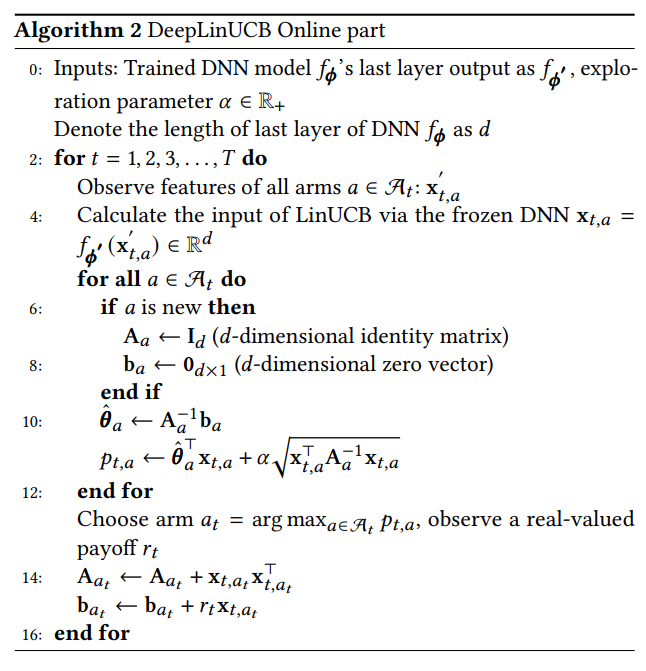

# Build LinUCB Algorithm

In [8]:
def choose_arm(contexts, A, b, alpha):
    max_pta = -np.inf
    chosen_arm = None

    for a in range(num_arms):
        x_a = contexts[a].reshape(-1, 1)
        A_inv = np.linalg.inv(A[a])
        theta_a = np.dot(A_inv, b[a])
        pta = np.dot(theta_a.T, x_a) + alpha * np.sqrt(np.dot(np.dot(x_a.T, A_inv), x_a))

        if pta > max_pta:
            max_pta = pta
            chosen_arm = a

    return chosen_arm,pta

In [9]:
def extract_context(dnn_model, X_tensor):
    with torch.no_grad():
        features = dnn_model.context(X_tensor).numpy()
    return features


In [10]:
dnn_model = DNN(input_dim=9)
dnn_model.eval()

alpha = 1.0

num_arms = 5
d = 128

user_context = [30,1,0,18]
contexts = []
arm = [
    [0, 0, 1, 0, 0.7],  #arm1
    [0, 1, 0, 0, 0.8],  #arm2
    [0, 1, 0, 0, 0.65], #arm3
    [0, 0, 0, 1, 0.3],  #arm4
    [1, 0, 0, 0, 0.7]   #arm5
]

for a in range(num_arms):
    current_context = user_context + arm[a]
    X_tensor = torch.tensor(current_context, dtype=torch.float32)
    x_ta = extract_context(dnn_model, X_tensor.unsqueeze(0))
    contexts.append(x_ta)

# Run model for real time reccommendation

In [11]:
A = [np.identity(d) for _ in range(num_arms)]
b = [np.zeros((d, 1)) for _ in range(num_arms)]

T = 1000 #constantly be running updating every 10 minutes
for t in range(T):
    chosen_arm,pta = choose_arm(contexts, A, b, alpha)


    reward = np.random.choice([0, 1])#Reward is set to raandom(will be the user clicking/not clicking within a certain time frame)


    x_chosen = contexts[chosen_arm].reshape(-1, 1)
    A[chosen_arm] += np.dot(x_chosen, x_chosen.T)
    b[chosen_arm] += reward * x_chosen

    print(f"Time {t + 1}: Resource Recommended = {chosen_arm}, Reward(Clicked or Not) = {reward}, pta = {pta}")


Time 1: Resource Recommended = 4, Reward(Clicked or Not) = 0, pta = [[10.7302667]]
Time 2: Resource Recommended = 0, Reward(Clicked or Not) = 1, pta = [[0.99568549]]
Time 3: Resource Recommended = 3, Reward(Clicked or Not) = 0, pta = [[0.99568549]]
Time 4: Resource Recommended = 1, Reward(Clicked or Not) = 1, pta = [[0.99568549]]
Time 5: Resource Recommended = 2, Reward(Clicked or Not) = 0, pta = [[0.99568549]]
Time 6: Resource Recommended = 0, Reward(Clicked or Not) = 0, pta = [[0.99568549]]
Time 7: Resource Recommended = 1, Reward(Clicked or Not) = 1, pta = [[0.99568549]]
Time 8: Resource Recommended = 1, Reward(Clicked or Not) = 1, pta = [[0.99568549]]
Time 9: Resource Recommended = 1, Reward(Clicked or Not) = 1, pta = [[0.99568549]]
Time 10: Resource Recommended = 1, Reward(Clicked or Not) = 1, pta = [[0.99568549]]
Time 11: Resource Recommended = 1, Reward(Clicked or Not) = 1, pta = [[0.99568549]]
Time 12: Resource Recommended = 1, Reward(Clicked or Not) = 1, pta = [[0.99568549]]
T